In [1]:
import sys
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
import json
import pandas as pd
import numpy as np
import glob 
from tabulate import tabulate 
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


pd.set_option('display.max_colwidth', None)

In [3]:
import torch 
import random
torch.manual_seed(123)
torch.cuda.manual_seed(123)
np.random.seed(123)
random.seed(123)

In [4]:
fivelvls_annotation_df = pd.read_pickle('../../data/five_levels_ds/annotation-results/MACE-measure/final_mace_predictions.pkl')
eli5_annotation_df     = pd.read_pickle('../../data/eli5_ds/annotation-results/MACE-measure/final_mace_predictions.pkl')

In [5]:
#correcting/aligning labels from the two datasets
# (D09) To provide informing statement -> (D10) To provide informing statement
# (D10) Other -> (D09) Other
# (E10) Other -> (E09) Other 
# (E09) Introducing Extraneous Information -> (E10) Introducing Extraneous Information
fivelvls_annotation_df['exp_act_label'] = fivelvls_annotation_df.exp_act_label.apply(lambda x: '(E09) Other' if x == '(E10) Other' else x)
fivelvls_annotation_df['exp_act_label'] = fivelvls_annotation_df.exp_act_label.apply(lambda x: '(E10) Introducing Extraneous Information' if x == '(E09) Introducing Extraneous Information' else x)

fivelvls_annotation_df['dlg_act_label'] = fivelvls_annotation_df.dlg_act_label.apply(lambda x: '(D09) Other' if x == '(D10) Other' else x)
fivelvls_annotation_df['dlg_act_label'] = fivelvls_annotation_df.dlg_act_label.apply(lambda x: '(E10) Introducing Extraneous Information' if x == '(E09) Introducing Extraneous Information' else x)

In [6]:
fivelvls_annotation_df['ds'] = ['5lvls'] * len(fivelvls_annotation_df)
eli5_annotation_df['ds'] = ['eli5'] * len(eli5_annotation_df)
dlgs_df = pd.concat([fivelvls_annotation_df, eli5_annotation_df])

In [7]:
dlgs_df['ds'].value_counts()

eli5     3873
5lvls    1550
Name: ds, dtype: int64

In [8]:
dlgs_df['turn_text_with_topic'] = dlgs_df.apply(lambda row: {
                                    'author': row['turn_text']['author'], 
                                    'text'  : row['topic'].replace('_', ' ') + ' [SEP] ' +  row['turn_text']['text']
                                   } ,axis=1)

In [9]:
dlgs_df.head()

,task_id,turn_id,topic_func_label,dlg_act_label,exp_act_label,topic,lvl,turn_text,ds,exp_type_label,post_link,post_id,turn_text_only,turn_text_with_topic
0,142,1,(T04) Other - No topic was introduced,(D09) To provide informing statement,(E02) Testing prior knowledge,virtual_reality,colleague,"{'author': 'Explainer', 'text': 'Mostly today, I've been talking a lot about what can we do, what's possible. We think might be possible in the next couple of years. But really at the professional level its more the question of wisdom of what should we be doing.'}",5lvls,NaN,NaN,NaN,NaN,"{'author': 'Explainer', 'text': 'virtual reality [SEP] Mostly today, I've been talking a lot about what can we do, what's possible. We think might be possible in the next couple of years. But really at the professional level its more the question of wisdom of what should we be doing.'}"
1,142,2,(T01) It is the main topic,(D09) To provide informing statement,(E03) Provide an explanation,virtual_reality,colleague,"{'author': 'Explainee', 'text': 'That's one of the things we're trying to figure out, from an artist and storytelling perspective, what are the things that will make this meaningfully different from what we're used to, like a television on our wall. And we've been finding a lot of things, aspects of virtual reality that very much do that in my opinion. Things that allow you to feel presence, first and foremost, where you get lost, and you have to remind yourself, this isn't actually happening. And things that ultimately allow you to embody other characters. Things where you can actually change your own self-perception and play with neuro-plasticity and teach yourself things that are bizarre and unique.'}",5lvls,NaN,NaN,NaN,NaN,"{'author': 'Explainee', 'text': 'virtual reality [SEP] That's one of the things we're trying to figure out, from an artist and storytelling perspective, what are the things that will make this meaningfully different from what we're used to, like a television on our wall. And we've been finding a lot of things, aspects of virtual reality that very much do that in my opinion. Things that allow you to feel presence, first and foremost, where you get lost, and you have to remind yourself, this isn't actually happening. And things that ultimately allow you to embody other characters. Things where you can actually change your own self-perception and play with neuro-plasticity and teach yourself things that are bizarre and unique.'}"
2,142,3,(T03) A related topic,(D09) To provide informing statement,(E03) Provide an explanation,virtual_reality,colleague,"{'author': 'Explainer', 'text': 'As an engineer of course, I love quantifiable things. I like saying here's my 18 millisecond motion to photon, here's my angular resolution that I'm improving. I'm doing the color-space right. But you can look not too far back where you say we have blu-ray DVDs at this amazing resolution, but more people want to watch Youtube videos at really bad early internet video speeds. Where there are things that if you deliver a value to people then these objective quantities may not be the most important thing. And while we're certainly pushing as hard as we can on lots of these things that make the experience better in potentially every way or maybe just for videos or for different things. I don't think that its necessary. I've commented that I think usually my favorite titles on mobile that are fully synthetic are ones that don't even try, they just go and do light-mapped, black-shaded. And I think its a lovely aesthetic. I think that you don't wind up fighting all of the aliasing. While you get some other titles that, oh we're gonna be high-tech with our specular bump maps with roughness. And you've got aliasing everywhere, and you can't hold frame rate and its all problematic. While some of these that are clearly very synthetic worlds where its nothing but these cartoony flat-shaded things with lighting, but they look and they feel good. And you can buy

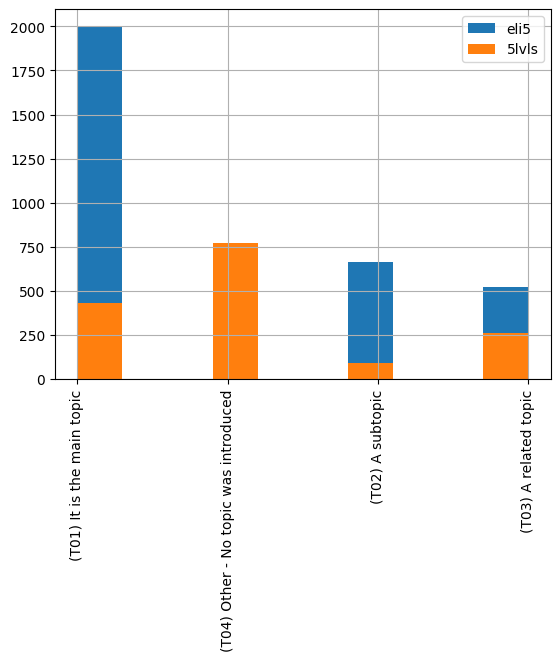

In [10]:
dlgs_df[dlgs_df.ds == 'eli5'].topic_func_label.hist(label='eli5')
dlgs_df[dlgs_df.ds == '5lvls'].topic_func_label.hist(label='5lvls')
plt.xticks(rotation=90)
plt.legend()
plt.show()

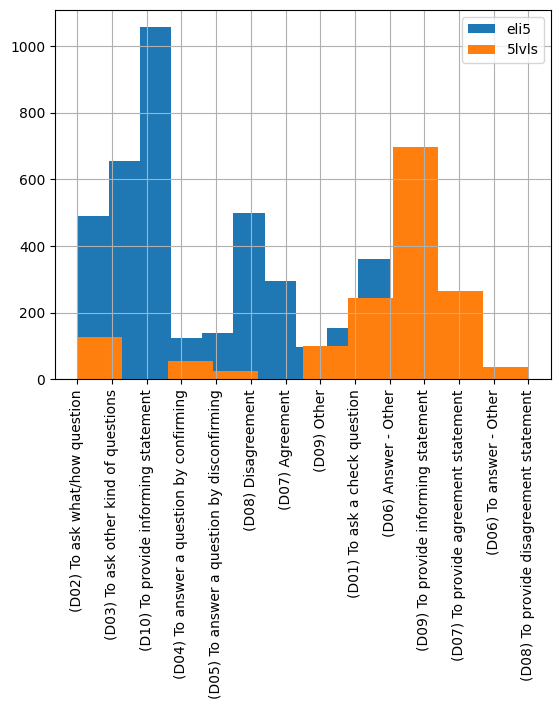

In [11]:
dlgs_df[dlgs_df.ds == 'eli5'].dlg_act_label.hist(label='eli5')
dlgs_df[dlgs_df.ds == '5lvls'].dlg_act_label.hist(label='5lvls')
plt.xticks(rotation=90)
plt.legend()
plt.show()

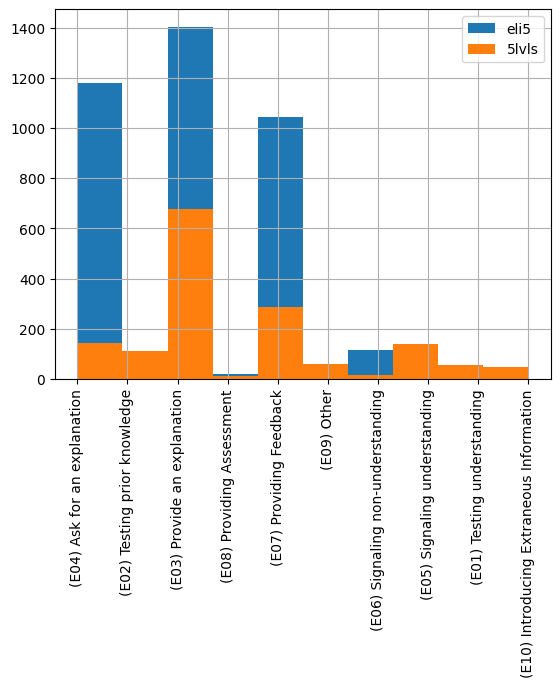

In [12]:
dlgs_df[dlgs_df.ds == 'eli5'].exp_act_label.hist(label='eli5')
dlgs_df[dlgs_df.ds == '5lvls'].exp_act_label.hist(label='5lvls')
plt.xticks(rotation=90)
plt.legend()
plt.show()

### Experiments:

- Train three models, one on eli5, one on 5lvls, and one on both, and evaluate them in three settings, in-domain and out-domain - through a 5-fold cross validation setting:
    - BERT
    - Longformer
    - Hatformer

### Training models:

In [13]:
import sys 

sys.path.insert(0, '../../../third-party/hierarchical-transformers/')

import torch
import json
from pathlib import Path
from datasets import load_dataset, Dataset, load_metric
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, default_data_collator,
                          PreTrainedModel, BertModel, BertForSequenceClassification,
                          TrainingArguments, Trainer)
from transformers.modeling_outputs import SequenceClassifierOutput

from torch.utils.data import DataLoader

import numpy as np
import pandas as pd

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from tabulate import tabulate
from glob import glob


In [14]:
from models.hat.modelling_hat import *
from models.hat.tokenization_hat import *

In [15]:
tokenizer = HATTokenizer.from_pretrained(
    "kiddothe2b/hierarchical-transformer-base-4096",
    do_lower_case=False,
    revision="main",
    use_auth_token=None,
    max_sentences=40,
    max_sen_length=100
)

model = HATModelForSequentialSentenceClassification.from_pretrained("kiddothe2b/hierarchical-transformer-base-4096", num_labels=10)

Some weights of the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 were not used when initializing HATModelForSequentialSentenceClassification: ['lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing HATModelForSequentialSentenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HATModelForSequentialSentenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HATModelForSequentialSentenceClassification were not initialized from the model checkpoint at kiddothe2b/hierarchical-transformer-b

In [16]:
grb_df = dlgs_df.groupby('task_id').agg({
    'turn_text' : lambda l: [x['text'] for x in l],
    'topic':            lambda l:  list(l)[0],
    'exp_act_label':    lambda l:  [int(x[2:4]) for x in l],
    'dlg_act_label':    lambda l:  [int(x[2:4]) for x in l],
    'topic_func_label': lambda l:  [int(x[2:4]) for x in l]
})

In [98]:
def preprocess_function(tokenizer, examples, input_clm, label_clm, padding=False, max_sen_length=100, max_sentences=40):
        # Tokenize the texts
        batch = tokenizer(
            examples[input_clm],
            padding=padding,
            max_length=max_sentences,
            truncation=True,
        )
        
        #[-100] * (max_sentences - len(examples[label_clm]))
        batch["label_ids"] = [[float(label) for label in labels] + [-100] * (max_sen_length - len(labels)) for labels in examples[label_clm]]

        return batch

In [99]:
training_ds = Dataset.from_pandas(grb_df[['turn_text', 'exp_act_label']])

In [100]:
training_ds = training_ds.map(lambda examples: preprocess_function(tokenizer, examples, input_clm="turn_text", label_clm='exp_act_label'),
                             remove_columns=['exp_act_label', 'turn_text', 'task_id'], batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

ArrowInvalid: cannot mix list and non-list, non-null values

In [101]:
training_ds

Dataset({
    features: ['input_ids', 'attention_mask', 'label_ids'],
    num_rows: 532
})

In [102]:
dl = DataLoader(training_ds)

In [103]:
args = TrainingArguments(
    output_dir= '../data/models/test',
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=1,
    weight_decay=0.01,
    eval_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model='f1-score'
)

trainer =Trainer(
    model,
    args,
    train_dataset=training_ds,
    eval_dataset=training_ds,
    compute_metrics=lambda x: compute_metrics(x),
    tokenizer=tokenizer
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 532
  Num Epochs = 1
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 133
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


IndexError: too many indices for tensor of dimension 2

### Training:

In [44]:
all_folds = json.load(open('../data/topic_folds.json'))

In [45]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [49]:
eval_results = run_experiment(dlgs_df, all_folds, 'exp_act_label', 'turn_text_with_topic', '../data/models/mixed_ds_models/model/', num_train_epochs=10, eval_steps=500, lr=2e-6, batch_size=16)
json.dump(eval_results, open('../data/models/mixed_ds_models/eval_results.json', 'w'))

In [ ]:
print(eval_results)

In [ ]:
print(np.mean([x['eval_f1-score'] for x in eval_results]))

In [ ]:
eval_results = run_experiment(dlgs_df[dlgs_df.ds=='eli5'].copy(), all_folds, 'exp_act_label', 'turn_text_with_topic', '../data/models/eli5_ds_models/model/', num_train_epochs=10, eval_steps=500, lr=2e-6, batch_size=16)
json.dump(eval_results, open('../data/models/eli5_ds_models/eval_results.json', 'w'))

In [ ]:
print(eval_results)

In [ ]:
eval_results = run_experiment(dlgs_df[dlgs_df.ds=='5lvls'].copy(), all_folds, 'exp_act_label', 'turn_text_with_topic', '../data/models/5lvls_ds/model/',  num_train_epochs=10, eval_steps=500, lr=2e-6, batch_size=16)

In [ ]:
json.dump(eval_results, open('../data/models/5lvls_ds/eval_results.json', 'w'))

In [25]:
print(eval_results)

[{'eval_loss': 1.2311949729919434, 'eval_f1-score': 0.33701284305370083, 'eval_runtime': 1.148, 'eval_samples_per_second': 263.927, 'eval_steps_per_second': 16.55, 'epoch': 10.0}, {'eval_loss': 1.5285849571228027, 'eval_f1-score': 0.38746475526922064, 'eval_runtime': 1.3609, 'eval_samples_per_second': 265.262, 'eval_steps_per_second': 16.9, 'epoch': 10.0}, {'eval_loss': 1.3738696575164795, 'eval_f1-score': 0.4319580652122655, 'eval_runtime': 1.7764, 'eval_samples_per_second': 236.998, 'eval_steps_per_second': 15.199, 'epoch': 10.0}, {'eval_loss': 1.2755420207977295, 'eval_f1-score': 0.3955496753660722, 'eval_runtime': 1.381, 'eval_samples_per_second': 220.132, 'eval_steps_per_second': 13.758, 'epoch': 10.0}, {'eval_loss': 1.160294532775879, 'eval_f1-score': 0.3568620128154209, 'eval_runtime': 0.6406, 'eval_samples_per_second': 251.322, 'eval_steps_per_second': 17.171, 'epoch': 10.0}]


In [35]:
print(tabulate([
    ['BERT Mixed Model'] + [round(np.mean([res['eval_f1-score'] for res in json.load(open('../data/models/5lvls_ds/eval_results.json'))]), 2)],
    ['BERT ELI5  Model'] + [round(np.mean([res['eval_f1-score'] for res in json.load(open('../data/models/mixed_ds_models/eval_results.json'))]), 2)],
    ['BERT 5Lvls Model'] + [round(np.mean([res['eval_f1-score'] for res in json.load(open('../data/models/eli5_ds_models/eval_results.json'))]), 2)]
], headers = ['Approach', 'ALL']))

Approach            ALL
----------------  -----
BERT Mixed Model   0.38
BERT ELI5  Model   0.41
BERT 5Lvls Model   0.34


### Prediction using the trained models:

In [47]:
folds_dict = json.load(open('../data/topic_folds.json'))
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [86]:
def evaluate_fold(fold_path, df, fold_idx, input_clm, label_clm='exp_act_label', ds_names=[]):
            
    model = AutoModelForSequenceClassification.from_pretrained(fold_path + 'best_model').to(device)
    model.eval()
    fold_topics = []
    if 'eli5' in ds_names:
        fold_topics += folds_dict['test']['eli5'][fold_idx]
    if '5lvls' in ds_names:
        fold_topics += folds_dict['test']['5lvls'][fold_idx]
    
    test_df  = df[df.topic.isin(fold_topics)]
    test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1) 
    
    eval_dataset = Dataset.from_pandas(test_df)
    eval_dataset = eval_dataset.map(lambda examples: preprocess_function(examples, input_clm), batched=True)
    eval_dataset = eval_dataset.remove_columns(test_df.columns.tolist() + ['__index_level_0__'])
    
    
    eval_dataloader = DataLoader(eval_dataset, collate_fn=default_data_collator)
    all_predictions = []
    for step, batch in enumerate(eval_dataloader):
        batch = {x[0]: x[1].cuda() for x in batch.items()}
        outputs = model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        all_predictions+=[x.item() for x in predictions]

    
    return f1_score(all_predictions, test_df['labels'].tolist(), average='macro')

In [87]:
eli5_f1_score = np.mean([evaluate_fold('../data/models/mixed_ds_models/model/fold-{}/'.format(fold), dlgs_df, fold,'turn_text_with_topic', ds_names=['eli5']) for fold in range(5)])
flvls_f1_score = np.mean([evaluate_fold('../data/models/mixed_ds_models/model/fold-{}/'.format(fold), dlgs_df, fold,'turn_text_with_topic',ds_names=['5lvls']) for fold in range(5)])
all_f1_score = np.mean([evaluate_fold('../data/models/mixed_ds_models/model/fold-{}/'.format(fold), dlgs_df, fold,'turn_text_with_topic', ds_names=['5lvls', 'eli5']) for fold in range(5)])

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/6 [00:00<?, ?ba/s]

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/1 [00:00<?, ?ba/s]

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/1 [00:00<?, ?ba/s]

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/1 [00:00<?, ?ba/s]

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/1 [00:00<?, ?ba/s]

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/1 [00:00<?, ?ba/s]

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/1 [00:00<?, ?ba/s]

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/1 [00:00<?, ?ba/s]

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/1 [00:00<?, ?ba/s]

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/1 [00:00<?, ?ba/s]

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/6 [00:00<?, ?ba/s]

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/2 [00:00<?, ?ba/s]

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/1 [00:00<?, ?ba/s]

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/1 [00:00<?, ?ba/s]

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/1 [00:00<?, ?ba/s]

In [88]:
eli5_eli5_f1_score = np.mean([evaluate_fold('../data/models/eli5_ds_models/model/fold-{}/'.format(fold), dlgs_df, fold,'turn_text_with_topic', ds_names=['eli5']) for fold in range(5)])
eli5_flvls_f1_score = np.mean([evaluate_fold('../data/models/eli5_ds_models/model/fold-{}/'.format(fold),dlgs_df, fold, 'turn_text_with_topic', ds_names=['5lvls']) for fold in range(5)])
eli5_all_f1_score = np.mean([evaluate_fold('../data/models/eli5_ds_models/model/fold-{}/'.format(fold), dlgs_df, fold, 'turn_text_with_topic', ds_names=['5lvls', 'eli5']) for fold in range(5)])

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/6 [00:00<?, ?ba/s]

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/1 [00:00<?, ?ba/s]

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/1 [00:00<?, ?ba/s]

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/1 [00:00<?, ?ba/s]

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/1 [00:00<?, ?ba/s]

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/1 [00:00<?, ?ba/s]

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/1 [00:00<?, ?ba/s]

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/1 [00:00<?, ?ba/s]

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/1 [00:00<?, ?ba/s]

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/1 [00:00<?, ?ba/s]

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/6 [00:00<?, ?ba/s]

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/2 [00:00<?, ?ba/s]

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/1 [00:00<?, ?ba/s]

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/1 [00:00<?, ?ba/s]

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/1 [00:00<?, ?ba/s]

In [89]:
flvls_eli5_f1_score = np.mean([evaluate_fold('../data/models/5lvls_ds/model/fold-{}/'.format(fold), dlgs_df, fold,'turn_text_with_topic', ds_names=['eli5']) for fold in range(5)])
flvls_flvls_f1_score = np.mean([evaluate_fold('../data/models/5lvls_ds/model/fold-{}/'.format(fold), dlgs_df, fold,'turn_text_with_topic', ds_names=['5lvls']) for fold in range(5)])
flvls_all_f1_score = np.mean([evaluate_fold('../data/models/5lvls_ds/model/fold-{}/'.format(fold), dlgs_df, fold,'turn_text_with_topic', ds_names=['5lvls', 'eli5']) for fold in range(5)])

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/6 [00:00<?, ?ba/s]

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/1 [00:00<?, ?ba/s]

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/1 [00:00<?, ?ba/s]

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/1 [00:00<?, ?ba/s]

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/1 [00:00<?, ?ba/s]

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/1 [00:00<?, ?ba/s]

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/1 [00:00<?, ?ba/s]

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/1 [00:00<?, ?ba/s]

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/1 [00:00<?, ?ba/s]

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/1 [00:00<?, ?ba/s]

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/6 [00:00<?, ?ba/s]

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/2 [00:00<?, ?ba/s]

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/1 [00:00<?, ?ba/s]

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/1 [00:00<?, ?ba/s]

<ipython-input-86-4d1847ef2cd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df[label_clm].apply(lambda x: int(x[2:4])-1)


  0%|          | 0/1 [00:00<?, ?ba/s]

In [90]:
from tabulate import tabulate
print(tabulate([
    ['BERT Mixed Model', all_f1_score, eli5_f1_score, flvls_f1_score],
    ['BERT ELI5  Model', eli5_all_f1_score, eli5_eli5_f1_score, eli5_flvls_f1_score],
    ['BERT 5Lvls Model', flvls_all_f1_score, flvls_eli5_f1_score, flvls_flvls_f1_score]
    ], 
    headers=['Approach', 'ALL', 'ELI5', '5lvls']))


Approach               ALL      ELI5     5lvls
----------------  --------  --------  --------
BERT Mixed Model  0.405418  0.314776  0.372802
BERT ELI5  Model  0.286139  0.342402  0.236211
BERT 5Lvls Model  0.309797  0.157714  0.381769
